<a href="https://colab.research.google.com/github/lrojasm407/Fall2022/blob/main/Copy_of_CE200A_Problem_Set_7_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CE200A: Environmental Fluid Mechanics

### Problem Set 7

**Course Professor:** Tina Chow (tinakc@berkeley.edu) (CEE, UC Berkeley)

**GSI:** Alexandre Georges (alexandre_georges@berkeley.edu) 

**Python expert:** Ajay B Harish (ajaybh@berkeley.edu) (SimCenter, UC Berkeley), with Adam Wise (adamwise@berkeley.edu) (CEE, UC Berkeley)

---

### Due date

Oct. 14 at 5pm

Describe the setup and each step in your solutions with words and clearly label your final answers. Use Python in Google Colab for plotting and programming. Use the ‘Print’ feature inside Google Colab which allows you to make a nice pdf of your code and plots.  Include your handwritten work in the pdf too.

###Question 01

Use modified wavenumber analysis (where $k′$ is the modified wavenumber) to compare the accuracy of the following schemes:

\begin{equation}
\begin{split}
f'_j &= \frac{f_{j+1} - f_{j-1}}{2\Delta} \ \text{2nd order}\\
f'_j &= \frac{f_{j-2} - 8f_{j-1} + 8f_{j+1} - f_{j+2}}{12\Delta} \ \text{4th order}
\end{split}
\end{equation}

Show how you derive $k′$ and then plot $k′\Delta$ vs. $k \Delta$ for $0 \le k\Delta \le \pi$ for both schemes and comment on the behavior.

In [82]:
# Reset all variables
%reset -f

# Import necessary modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


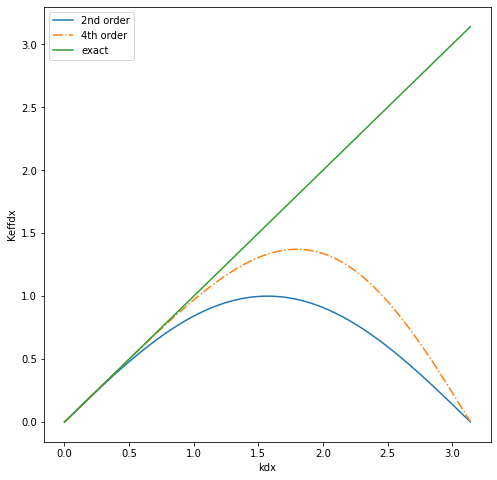

In [83]:
kdx = np.arange(0,np.pi,0.01)
Keff_1_dx=np.sin(kdx)
Keff_2_dx=(8*np.sin(kdx)-np.sin(2*kdx))/6
exact=kdx

fig, main_ax = plt.subplots()
fig.set_size_inches(8, 8) #this just makes the figure a bit bigger below
main_ax.plot(kdx, Keff_1_dx,'-', kdx, Keff_2_dx,'-.', kdx, exact)
main_ax.set_xlabel('kdx')
main_ax.set_ylabel('Keffdx')
main_ax.legend(['2nd order', '4th order','exact'])

Notice that for a given grid size (dx constant) both schemes are more accurate at low k.  Something very interesting happens for kdx=1.5, In this case the 4th order scheme has a lower error than the 2nd order scheme. This means that for a function with more variation (oscillation) a higher order scheme will result in a lower error (asssuming equal grid size)

### Question 02

Consider the 1D steady-state diffusion problem:

\begin{equation}
\frac{\partial^2 \phi}{\partial x^2} = 0
\end{equation}

over the domain $x=0$ to 1 with $\phi = 2$ at $x=0$ and $\phi = 3$ at $x=1$. Solve this using a second-order finite difference scheme (as done in the lecture video). Set up the tridiagonal matrix that you will solve.

(a) Use the Thomas algorithm to solve the problem using Python. (Note: You can write the Thomas algorithm as a function in Python as it may come in handy in future assignments. See the function thomasalg() given below for a template.) Make your code adjustable for any number of grid points and plot the solution for N = 21.

(b) To convince yourself that the Thomas algorithm is worth using for a tridiagonal matrix, make some computational cost comparisons. First, set up a full tridiagonal matrix (with all the zeros stored) and use Python’s ```linalg.splu``` solver from ```scipy``` to determine the solution. 

**Hint:** You need to fill the tri-diagonal array first. You can do this using

```python
A = np.diag(np.delete(a,0),-1) + np.diag(np.delete(c,len(c)-1),-1) 
np.fill_diagonal(A,b)
```
Then call the python function to solve sparse square matrices using an LU decomposition. If $\bf{A}\cdot\bf{x} = \bf{d}$ then to find $\bf{x} = \bf{A}^{-1}\cdot\bf{d}$ use

```python
import scipy.linalg as la
from scipy.linalg import solve
from scipy import sparse
import scipy.sparse.linalg
x = sparse.linalg.splu(A).solve(d)
```

To compare the computational cost of this approach to the Thomas algorithm you used above, you need to record how much time it takes for python to compute the answers. Use the function

```python
import time
t0 = time.time()
[Solution steps go here]
timetaken = time.time() - t0
```
to determine the time to obtain each solution.

The Python linalg.splu algorithm is specialized for tridiagonal matrices and fairly fast because of all the zeros. To get a sense of what full Gaussian elimination would cost, also compare your timings to a full matrix (no zeros) inversion by setting up a sample matrix using

```python
B = (10*np.random.random((N,N)).astype(int)
dd = np.arange(N)
phi_magic = solve(B,dd)
```

You will have to use large $N$ before you see differences between these 3 solution costs. Plot the timings for various $N$ values. Discuss the advantages of using the Thomas algorithm for solving a tridiagonal matrix.


### Solution 02

The steps and code to solve this problem are outlined here. Fill in the details!

Write out the tridiagonal matrix setup for this problem first [and make sure you know how to do this on your own]:
\begin{equation}
\begin{bmatrix} 1 &0&0&&...& &0 \\ 
1 &-2&1&&&& \\0 &1&-2&1&& &\vdots\\
&&\ddots&\ddots&\ddots&&  \\
\vdots&&&1&-2&1&0\\
&&&&1&-2&1\\
0 &&...&&0&0&1\end{bmatrix} 
\begin{bmatrix}
\Phi_1 \\\Phi_2\\ \vdots \\ \Phi_{N-1}\\\Phi_N
\end{bmatrix} = 
\begin{bmatrix}
2 \\0 \\ \vdots \\ 0\\3
\end{bmatrix}
\end{equation}

In [84]:
# Reset all variables
%reset -f

# Import necessary modules
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

Start by writing a function to do the Thomas algorithm.

In [85]:
# Define the function for Thomas algorithm
def thomasalg(a,b,c,d):

    # Inputs: a, b, c are the diagonals of the matrix
    # All the input vectors are of the same length
    # Input: d is the RHS such that A*x = d
    # Output: x is the solution to A*x = d

    # Get the number of rows in the matrix
    n = len(b)

    # Initialize x (solution)
    x = np.empty([n])

    # Forward sweep
    bnew = b
    for ii in range(1,n):
        bnew[ii] = b[ii]-a[ii]*c[ii-1]/bnew[ii-1]
        d[ii] = d[ii]-d[ii-1]*a[ii]/bnew[ii-1]

    # Backward substitution
    x[n-1] = d[n-1]/bnew[n-1]
    for ii in range(n-2,-1,-1):
        x[ii] = (d[ii]-c[ii]*x[ii+1])/bnew[ii]

    # Return the solution
    return x

Test your Thomas algorithm with a simple case to make sure it's working:

In [86]:
N=21
# Initialize the four arrays
a = np.zeros([N,1]); a[0] = np.NaN; a[N-1] = 0
b = np.ones([N,1]); b[0] = 1; b[N-1] = 1
c = np.zeros([N,1]); c[0] = 0; c[N-1] = np.NaN
d = 2*np.ones([N,1]); d[0] = 2; d[N-1] = 2

# Initialize x, from 0 to 1 with N grid cells
x = np.linspace(0,1,N)

# Solve using the Thomas algorithm
phi = thomasalg(a,b,c,d)

print(phi)  #it should be an array of 2's

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


(a) The solution with 21 grid points:

Text(0.5, 1.0, 'PS 7 Problem 2a - Steady state diffusion')

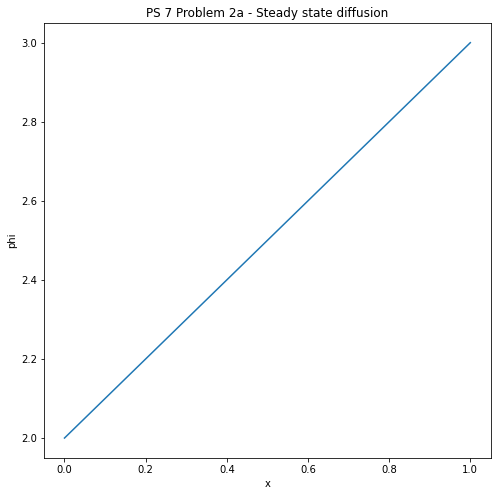

In [87]:
# Initialize size of array
N = 21 #21 grid points

# Initialize the four arrays
a = np.ones([N,1]); a[0] = np.NaN; a[N-1] = 0
b = -2*np.ones([N,1]); b[0] = 1; b[N-1] = 1
c = np.ones([N,1]); c[0] = 0; c[N-1] = np.NaN
d = np.zeros([N,1]); d[0] = 2; d[N-1] = 3


# Initialize x, from 0 to 1 with N-1 grid cells
x = np.linspace(0,1,N)

# Solve using the Thomas algorithm
phi = thomasalg(a,b,c,d)

# Plot the solution
fig, main_ax = plt.subplots()
fig.set_size_inches(8, 8)
main_ax.plot(x,phi)
main_ax.set_xlabel('x')
main_ax.set_ylabel('phi')
main_ax.set_title('PS 7 Problem 2a - Steady state diffusion')
#make sure this looks like you expect it to!

In [ ]:
print(phi) 

[2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65
 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]


(b) The code and the plot for the computational time are given below. You just need to follow through to understand what it's doing and enter the matrix you want to solve, as above. The computational cost calculation is defined as a function so you can call it to create plots with different matrix sizes; see below.

In [88]:
# Import additional modules for solving matrices
import scipy.linalg as la
from scipy.linalg import solve
from scipy import sparse
import scipy.sparse.linalg
import time as time

# Function for plotting matrix computation times
def matrixsolvetimes(matsize):

    # Initialize arrays for solutions and times
    steps = int(matsize/100)
    NN = np.zeros([steps])
    timeToThomas = np.zeros([steps])
    timeToSolveFullMatrix = np.zeros([steps])
    timeToSolveTridiagSPLU = np.zeros([steps])
    
    # Counter
    ii = 0

    # This loops over different values of N and calculates the time it takes 
    # to solve the matrix for the Thomas algorithm vs Python's built-in 
    # sparse matrix solver (SPLU). It also compares the cost of solving a full
    # matrix (no zeros) using a Gaussian elimination solver.
    for N in range(100, 100*(steps+1), 100):
        
        # Thomas algorithm
        # Initialize the four arrays
        # these lines should be the same as the arrays you defined in the previous code cell above
        a = np.ones([N,1]); a[0] = np.NaN; a[N-1] = 0
        b = -2*np.ones([N,1]); b[0] = 1; b[N-1] = 1
        c = np.ones([N,1]); c[0] = 0; c[N-1] = np.NaN
        d = np.zeros([N,1]); d[0] = 2; d[N-1] = 3

        # Get time to execute the Thomas algorithm
        t1 = time.time()
        phi_t = thomasalg(a,b,c,d)
        timeToThomas[ii] = time.time() - t1

        # Get the time to execute the linalg.splu algorithm (for sparse matrices)
        # Solve the tridiagonal matrix defined here
        A = np.diag(np.delete(a,0),-1) + np.diag(np.delete(c,len(c)-1),-1) 
        np.fill_diagonal(A,b) #create full tridiagonal A matrix
        t2 = time.time()
        phi_m = sparse.linalg.spsolve(A,b)
        timeToSolveTridiagSPLU[ii] = time.time()-t2

        # Get the time to execute the linalg algorithm (for full matrix)
        # Solve the full matrix 
        B = (10*np.random.random((N,N))).astype(int) #create random full matrix
        dd = np.arange(N) #create random d (right hand side vector)
        t3 = time.time()
        phi_full = solve(B, dd)
        timeToSolveFullMatrix[ii] = time.time() - t3

        NN[ii] = N
        ii = ii + 1 #increment the counter

    # Plot
    fig, main_ax = plt.subplots()
    fig.set_size_inches(8, 8)
    main_ax.plot(NN,timeToThomas,'o-',NN,timeToSolveTridiagSPLU,'s-',NN,timeToSolveFullMatrix,'d-')
    main_ax.set_xlabel('N')
    main_ax.set_ylabel('Time to Compute [s]')
    main_ax.set_title('PS 7 Problem 2b - Computation time')
    main_ax.legend(['Thomas algorithm', 'Python solver - Tridiagonal','Python solver - full matrix'])

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


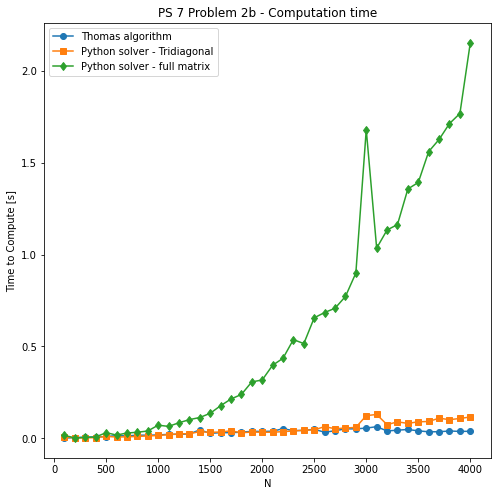

In [89]:
# Plot the computational times for matrix size of up to 2000
matsize = 4000
matrixsolvetimes(matsize)

Add some comments about the plot above. It might help to run the comparison for larger matrix sizes, up to 4000 or 5000

There are significant time benefits when running the Thomas algorithm. The difference becomes more clear for large N values. 


### Question 03

Consider the unsteady 1D scalar diffusion equation

\begin{equation}
\frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}
\end{equation}

given the initial and boundary conditions:

\begin{equation}
\begin{split}
c(x,0) &= 1 \ \text{for} \ |x| < 0.3 \\
c(x,0) &= 0 \ \text{for} \ |x| \ge 0.3 \\
\frac{\partial c}{\partial x} \vert_{(-2,t)} &= 0, \frac{\partial c}{\partial x} \vert_{(2,t)} &= 0
\end{split}
\end{equation}

Solve this equation numerically for $D = 0.1$.

(a) Use first-order explicit time stepping with central differences in space to compute the numerical solution. Use 60 grid cells (61 grid points) and select $r = 0.45$. Implement a second-order one-sided difference for the treatment of the boundary conditions. Plot your initial concentration profile, as well as the results at $t = 0.1, 1$ s. Discuss your results.

(b) Use superposition to state the analytical solution to this problem with the same initial conditions but in an infinite domain. (This is similar to Problem Set 5 #3b.) Plot the analytical solution with your numerical results at $t = 1$ s and discuss differences.

(c) Now run the code again using $c = 2 + x + \sin{(2\pi x)}$ as the initial condition, with $c(0,t) = 2$ and $c(1,t) = 3$ for boundary conditions (i.e. for the smaller domain in the previous problem). Discuss and plot the behavior of the solution as the code advances to steady state. (**Note:** you can create a branch in your code using an if statement to switch different boundary conditions or initial conditions on and off, so you can easily switch between options for parts (a) and (c), or you can create another copy of your code with the necessary changes.)

### Solution 03

Follow the steps and code outline provided here, and fill in the details.

Discretize the equation by hand and carefully write out the boundary conditions. It's recommended that you write out pseudo-code so you have a clear plan for your code structure and/or so you understand what is done in the template below.

In [92]:
# Clear all variables
%reset -f

# Import necessary modules
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import special

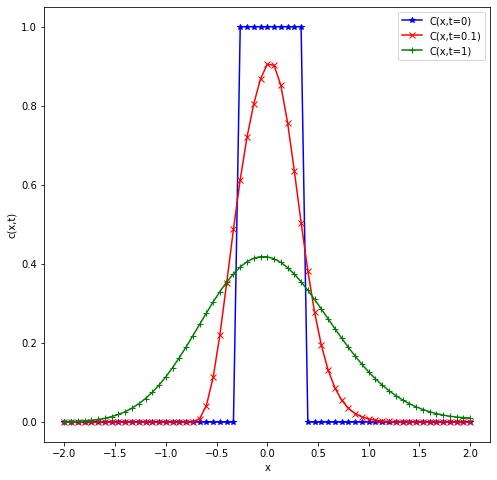

In [107]:
    # Set the number of grid cells
    N = 60

    # Set the parameters
    D = 0.1
    r = 0.45
    # Define BC and IC 
    L = 2
    dx = 2*L/(N)
    x = np.arange(-L,L+dx,dx)
    nx = N+1 #number of grid points
    c0 = np.zeros([nx,1]) ; c0[np.abs(x+0.3).argmin(): np.abs(x-0.3).argmin()+1]=1

    # Define time step and time array
    dt = r*dx*dx/D  #adjust dt based on the chosen dx and r values
    time = np.arange(0,1+dt,dt) #time goes up to 1 sec
    nt = len(time)

    # Initialize the "c" variable with the initial
    # conditions defined above. Apply BC at both ends
    c = np.array(c0) #initial condition
    c[0] = (3*c[1]-c[2])/2
    c[nx-1] = (3*c[nx-2]-c[nx-3])/2

    # Main time advancement loop using explicit Euler in time, central in space
    for n in range (nt):

        # Update to new time step
        c_old = np.array(c)

        # Loop in space
        for ii in range (1,nx-1):
            c[ii] = (1-2*r)*c[ii]+r*(c[ii-1]+c[ii+1])

        # Update BC before the end of the time step
        c[0] =  (3*c[1]-c[2])/2
        c[nx-1] = (3*c[nx-2]-c[nx-3])/2 

        # Save for plotting 
        if n == math.floor(nt/10): #store data at 0.1 sec, 1/10 of the way
            cmid = np.array(c)

    # Plot the results
    fig, main_ax = plt.subplots()
    fig.set_size_inches(8, 8)
    main_ax.plot(x, c0,'b-*',x, cmid,'r-x',x, c,'g-+')
    main_ax.set_xlabel('x')
    main_ax.set_ylabel('c(x,t)')
    main_ax.legend(['C(x,t=0)', 'C(x,t=0.1)', 'C(x,t=1)'])

   

The information travels at a finite speed. This is similar to the analytical solution. 

(b) Write out the analytical solution then compare to the finite difference solution.

Text(0.5, 1.0, 'PS 7 Problem 3b, C(x,t) at t = 1s')

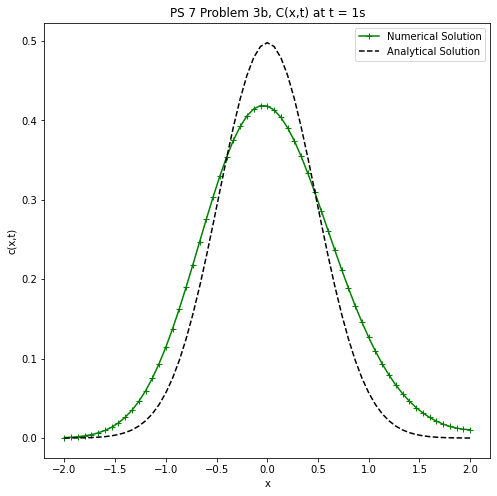

In [105]:
# Provide the time to compare solutions
t = 1 #1 sec

# Initialize array for cAnalytical
cAnalytical = np.empty([len(x)])

# Calculate the analytical solution
for ii in range(len(x)):
    cAnalytical[ii] = 0.5*1.0*(special.erf((x[ii]+0.3)/np.sqrt(4*D*t))-special.erf((x[ii]-0.3)/np.sqrt(4*D*t)))

# Plot the analytical solution
fig, main_ax = plt.subplots()
fig.set_size_inches(8, 8)
main_ax.plot(x, c,'g-+',x, cAnalytical,'k--')
main_ax.set_xlabel('x')
main_ax.set_ylabel('c(x,t)')
main_ax.legend(['Numerical Solution','Analytical Solution'])
main_ax.set_title('PS 7 Problem 3b, C(x,t) at t = 1s')

(c) Modify your code from part (a) above to handle the different boundary and initial conditions.

This could mean creating a new version of the code with these new options, or modifying the version above to have the ability to handle both options.


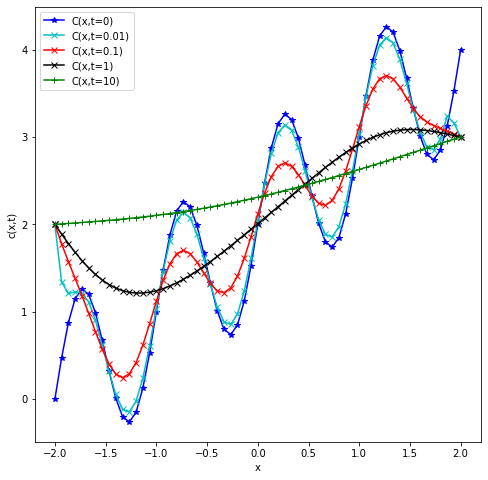

In [135]:
    # Set the number of grid cells
    N = 60

    # Set the parameters
    D = 0.1
    r = 0.45
    # Define BC and IC 
    L = 2
    dx = 2*L/(N)
    x = np.arange(-L,L+dx,dx)
    nx = N+1 #number of grid points
    c0 = 2+x+np.sin(2*np.pi*x)

    # Define time step and time array
    dt = r*dx*dx/D  #adjust dt based on the chosen dx and r values
    time = np.arange(0,10+dt,dt) #time goes up to 10 sec
    nt = len(time)

    # Initialize the "c" variable with the initial
    # conditions defined above. Apply BC at both ends
    c = np.array(c0) #initial condition
    c[0] = 2
    c[nx-1] = 3

    # Main time advancement loop using explicit Euler in time, central in space
    for n in range (nt):

        # Update to new time step
        c_old = np.array(c)

        # Loop in space
        for ii in range (1,nx-1):
            c[ii] = (1-2*r)*c[ii]+r*(c[ii-1]+c[ii+1])

        # Update BC before the end of the time step
        c[0] =  2
        c[nx-1] = 3 

        # Save for plotting 
        if n == math.floor(nt/1000): #store data at 0.01 sec, 1/1000 of the way
            cmid0 = np.array(c)

        if n == math.floor(nt/100): #store data at 0.1 sec, 1/100 of the way
            cmid = np.array(c)

        if n == math.floor(nt/10): #store data at 1 sec, 1/10 of the way
            cmid2 = np.array(c)



    # Plot the results
    fig, main_ax = plt.subplots()
    fig.set_size_inches(8, 8)
    main_ax.plot(x, c0,'b-*',x, cmid0,'c-x', x, cmid,'r-x',x, cmid2,'k-x',x, c,'g-+')
    main_ax.set_xlabel('x')
    main_ax.set_ylabel('c(x,t)')
    main_ax.legend(['C(x,t=0)', 'C(x,t=0.01)','C(x,t=0.1)', 'C(x,t=1)','C(x,t=10)'])
